In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb

from statsmodels.compat import lzip
import statsmodels.api as sm

# Introduction

In this project, we'll forecast the Global Indicator of Economic Activity (IGAE) in Mexico using XGBoost.

In [2]:
df = pd.read_csv('/content/Datos_PIB.csv')
df.head(5)

,FECHAS,INPC,OPETDC,OPETOT,OPETDD,MONRTDC,MONRTOT,MONRTDD,MOVGGE,MOVGGF,...,TIIE,TCR,IMP,IMP_NP,IMP_BC,X,X_M,IMAI,IGAE,PIB
0,01/01/2010,72.552046,28559378,77282436,48723058,279438830.8,544252783.8,264813953.0,100.0,100.0,...,4.910030,105.462083,19634.064,17288.730,3033.443,19189.889,15234.048,92.981275,86.867020,NaN
1,01/02/2010,72.971671,26825564,69075135,42249571,245778850.5,457097675.6,211318825.2,100.0,100.0,...,4.917342,106.154274,20879.793,18868.130,2801.730,21302.600,17396.751,88.696326,85.227165,NaN
2,01/03/2010,73.489725,32529959,83409924,50879965,308072048.5,564372607.6,256300559.2,100.0,100.0,...,4.923182,102.992372,25710.897,23250.796,3269.602,26104.127,21398.029,96.826787,92.292285,14730794.96
3,01/04/2010,73.255565,30619781,79677720,49057939,275413992.3,514939693.3,239525701.1,100.0,100.0,...,4.937015,100.450573,24764.007,22109.363,3508.946,24844.517,20385.828,94.777620,90.581818,NaN
4,01/05/2010,72.793978,32218409,88365649,56147240,308830992.0,591466541.9,282635549.9,100.0,100.0,...,4.943524,104.806818,24623.978,21960.689,3480.744,24796.461,19898.738,95.143666,92.300049,NaN


In [3]:
df.columns

Index(['FECHAS', 'INPC', 'OPETDC', 'OPETOT', 'OPETDD', 'MONRTDC', 'MONRTOT',
       'MONRTDD', 'MOVGGE', 'MOVGGF', 'MOVGGO', 'MOVGGP', 'MOVGGR', 'MOVGGW',
       'PETROLEO', 'HOT_PO', 'REMESAS', 'DIESEL', 'GASOLINA', 'COVIDC',
       'TURBOSINA', 'IPM', 'RAIAVL_P', 'RAIAVL_V', 'INPRO', 'IATM',
       'METROCDMX', 'METROMTY', 'ASALLE', 'ASASAL', 'CUARTOS', 'CUARTOS2',
       'ENOEPO', 'ENOEPEA', 'IMSS', 'TIIE', 'TCR', 'IMP', 'IMP_NP', 'IMP_BC',
       'X', 'X_M', 'IMAI', 'IGAE', 'PIB'],
      dtype='object')

The dataset consists of key economic variables such as employment, expenditures via credit and debit cards, production of oil and cars, occupation in hotels, exports, imports, etc. 

We will add a new column with the number of days of each month to deal with the seasonality of the time series. Also, feature-engineering is applied to the energy consumption of different types of fuel.

In [4]:
df['days'] = pd.to_datetime(df.FECHAS, format = '%d/%m/%Y').apply(lambda t: pd.Period(t, freq='S').days_in_month)
df['PETROLEO'] = df['PETROLEO'] * df['days']
df['DIESEL'] = df['DIESEL'] * df['days']
df['GASOLINA'] = df['GASOLINA'] * df['days']
df['TURBOSINA'] = df['TURBOSINA'] * df['days']

# Data preprocessing

Next, a new table was created with the first difference between the series to ensure all series are stationary.

In [14]:
df_dif = df.drop(['FECHAS','PIB','days'], axis = 1).diff()
df_dif['FECHAS'] = df['FECHAS'].copy()
df_dif['days'] = df['days'].copy()
df_dif

,INPC,OPETDC,OPETOT,OPETDD,MONRTDC,MONRTOT,MONRTDD,MOVGGE,MOVGGF,MOVGGO,...,TCR,IMP,IMP_NP,IMP_BC,X,X_M,IMAI,IGAE,FECHAS,days
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/01/2010,31
1,0.419625,-1733814.0,-8207301.0,-6473487.0,-33659980.3,-87155108.2,-53495127.8,0.000000,0.000000,0.000000,...,0.692192,1245.729,1579.400,-231.713,2112.711,2162.703,-4.284950,-1.639855,01/02/2010,28
2,0.518055,5704395.0,14334789.0,8630394.0,62293198.0,107274932.0,44981734.0,0.000000,0.000000,0.000000,...,-3.161902,4831.104,4382.666,467.872,4801.527,4001.278,8.130461,7.065121,01/03/2010,31
3,-0.234161,-1910178.0,-3732204.0,-1822026.0,-32658056.2,-49432914.3,-16774858.1,0.000000,0.000000,0.000000,...,-2.541799,-946.890,-1141.433,239.344,-1259.610,-1012.201,-2.049167,-1.710467,01/04/2010,30
4,-0.461587,1598628.0,8687929.0,7089301.0,33416999.7,76526848.6,43109848.8,0.000000,0.000000,0.000000,...,4.356244,-140.029,-148.674,-28.202,-48.056,-487.090,0.366046,1.718231,01/05/2010,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.979000,-3483385.0,-30544557.0,-27061172.0,-52511316.0,-203230670.0,-150719354.0,8.923963,4.471198,7.861751,...,0.169931,4767.712,5045.150,10.399,12332.016,11547.138,-4.756980,-2.041379,01/02/2022,28
146,1.178000,18942834.0,57553536.0,38610702.0,117718930.9,240622498.0,122903567.0,2.366360,-0.277650,-0.184332,...,1.277015,6848.606,5499.496,1346.364,5666.882,4579.582,6.992298,6.703767,01/03/2022,31
147,0.650000,-1950913.0,-1875297.0,75616.0,-35565849.8,-52506454.0,-16940605.0,0.886021,1.241936,1.312903,...,-3.662524,-2438.151,-2913.347,-375.520,-4426.679,-4361.610,-3.820432,-2.447685,01/04/2022,30
148,0.213000,11373467.0,38507583.0,27134116.0,114649881.6,231415084.0,116765203.0,4.715151,4.241936,3.332258,...,1.639692,2856.920,2009.925,334.694,2525.668,2494.690,2.012978,4.867214,01/05/2022,31


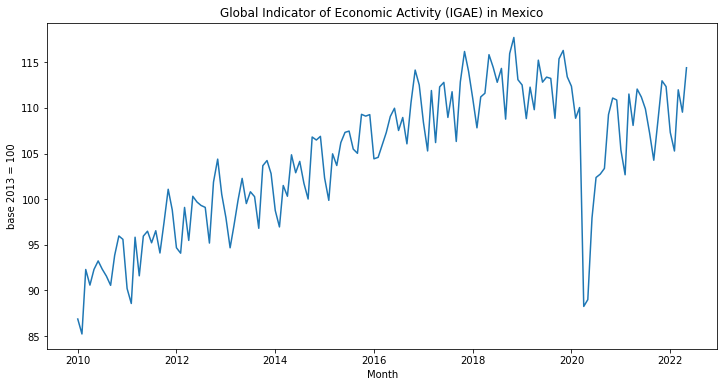

In [12]:
plt.figure(figsize = (12, 6))
plt.plot(pd.to_datetime(df.FECHAS, format = '%d/%m/%Y'), df.IGAE)
plt.title('Global Indicator of Economic Activity (IGAE) in Mexico')
plt.ylabel('base 2013 = 100')
plt.xlabel('Month')
plt.show()

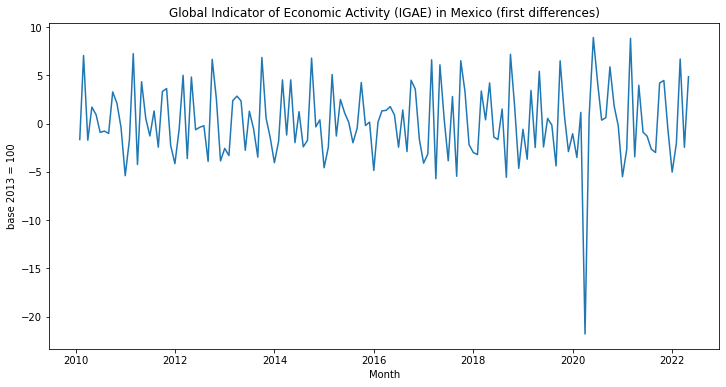

In [15]:
plt.figure(figsize = (12, 6))
plt.plot(pd.to_datetime(df_dif.FECHAS, format = '%d/%m/%Y'), df_dif.IGAE)
plt.title('Global Indicator of Economic Activity (IGAE) in Mexico (first differences)')
plt.ylabel('base 2013 = 100')
plt.xlabel('Month')
plt.show()

We'll add new columns which indicate the month and quarter of each observation.

In [16]:
def one_hot_dates(data):
  data.loc[:,'QUARTER'] = data['FECHAS'].dt.quarter
  data.loc[:,'MONTH'] = data['FECHAS'].dt.month
  data.loc[:,'QUARTER'] = data.loc[:,'QUARTER'].astype('category')
  data.loc[:,'MONTH'] = data.loc[:,'MONTH'].astype('category')
  data = pd.get_dummies(data)
  return data

In [17]:
df_dif.FECHAS = pd.to_datetime(df_dif.FECHAS, format = '%d/%m/%Y')
df_dif = one_hot_dates(df_dif)
df_dif.drop(['FECHAS'], axis = 1, inplace = True)
df_dif.isnull().sum()

INPC         1
OPETDC       1
OPETOT       1
OPETDD       1
MONRTDC      1
MONRTOT      1
MONRTDD      1
MOVGGE       1
MOVGGF       1
MOVGGO       1
MOVGGP       1
MOVGGR       1
MOVGGW       1
PETROLEO     1
HOT_PO       1
REMESAS      2
DIESEL       1
GASOLINA     1
COVIDC       1
TURBOSINA    1
IPM          1
RAIAVL_P     1
RAIAVL_V     1
INPRO        1
IATM         1
METROCDMX    2
METROMTY     2
ASALLE       2
ASASAL       2
CUARTOS      1
CUARTOS2     1
ENOEPO       1
ENOEPEA      1
IMSS         1
TIIE         1
TCR          1
IMP          2
IMP_NP       2
IMP_BC       2
X            2
X_M          2
IMAI         2
IGAE         2
days         0
QUARTER_1    0
QUARTER_2    0
QUARTER_3    0
QUARTER_4    0
MONTH_1      0
MONTH_2      0
MONTH_3      0
MONTH_4      0
MONTH_5      0
MONTH_6      0
MONTH_7      0
MONTH_8      0
MONTH_9      0
MONTH_10     0
MONTH_11     0
MONTH_12     0
dtype: int64

In [21]:
df_dif = df_dif.iloc[1:]
df_dif

,INPC,OPETDC,OPETOT,OPETDD,MONRTDC,MONRTOT,MONRTDD,MOVGGE,MOVGGF,MOVGGO,...,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
1,0.419625,-1733814.0,-8207301.0,-6473487.0,-33659980.3,-87155108.2,-53495127.8,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,0.518055,5704395.0,14334789.0,8630394.0,62293198.0,107274932.0,44981734.0,0.000000,0.000000,0.000000,...,1,0,0,0,0,0,0,0,0,0
3,-0.234161,-1910178.0,-3732204.0,-1822026.0,-32658056.2,-49432914.3,-16774858.1,0.000000,0.000000,0.000000,...,0,1,0,0,0,0,0,0,0,0
4,-0.461587,1598628.0,8687929.0,7089301.0,33416999.7,76526848.6,43109848.8,0.000000,0.000000,0.000000,...,0,0,1,0,0,0,0,0,0,0
5,-0.022794,-698600.0,-3969609.0,-3271009.0,-12565057.6,-37352942.8,-24787885.2,0.000000,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.979000,-3483385.0,-30544557.0,-27061172.0,-52511316.0,-203230670.0,-150719354.0,8.923963,4.471198,7.861751,...,0,0,0,0,0,0,0,0,0,0
146,1.178000,18942834.0,57553536.0,38610702.0,117718930.9,240622498.0,122903567.0,2.366360,-0.277650,-0.184332,...,1,0,0,0,0,0,0,0,0,0
147,0.650000,-1950913.0,-1875297.0,75616.0,-35565849.8,-52506454.0,-16940605.0,0.886021,1.241936,1.312903,...,0,1,0,0,0,0,0,0,0,0
148,0.213000,11373467.0,38507583.0,27134116.0,114649881.6,231415084.0,116765203.0,4.715151,4.241936,3.332258,...,0,0,1,0,0,0,0,0,0,0


In [22]:
df_dif.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 1 to 149
Data columns (total 60 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   INPC       149 non-null    float64
 1   OPETDC     149 non-null    float64
 2   OPETOT     149 non-null    float64
 3   OPETDD     149 non-null    float64
 4   MONRTDC    149 non-null    float64
 5   MONRTOT    149 non-null    float64
 6   MONRTDD    149 non-null    float64
 7   MOVGGE     149 non-null    float64
 8   MOVGGF     149 non-null    float64
 9   MOVGGO     149 non-null    float64
 10  MOVGGP     149 non-null    float64
 11  MOVGGR     149 non-null    float64
 12  MOVGGW     149 non-null    float64
 13  PETROLEO   149 non-null    float64
 14  HOT_PO     149 non-null    float64
 15  REMESAS    148 non-null    float64
 16  DIESEL     149 non-null    float64
 17  GASOLINA   149 non-null    float64
 18  COVIDC     149 non-null    float64
 19  TURBOSINA  149 non-null    float64
 20  IPM       

All columns are numeric, so we are able to train a model. First, let's divide the target variable $y$ and the predictors $X$.

In [38]:
X_data = df_dif.drop(columns = ['IGAE']).copy()
y_data = df_dif['IGAE'].copy()
X_val = X_data.tail(1)
X_data = X_data[:-1]
y_data = y_data[:-1]

Let's split the data into train and test set, the last 8 observations are used to check the performance.

In [39]:
nrows = df_dif.shape[0]
n_for = 8
X_train, X_test = X_data.iloc[:(nrows-n_for),], X_data.iloc[(nrows-n_for):,]
y_train, y_test = y_data.iloc[:(nrows-n_for),], y_data.iloc[(nrows-n_for):,]
print(f'The X_train shape is: {X_train.shape}')
print(f'The X_test shape is: {X_test.shape}')
print(f'The y_train shape is: {y_train.shape}')
print(f'The y_test shape is: {y_test.shape}')

The X_train shape is: (141, 59)
The X_test shape is: (7, 59)
The y_train shape is: (141,)
The y_test shape is: (7,)


# XGBoost Model

In [40]:
reg = xgb.XGBRegressor(n_estimators = 200,
                       max_depth = 4, 
                       learning_rate = 0.05,
                       colsample_bytree = 0.5,
                       objective='reg:squarederror',
                       reg_lambda = 0.001,
                       reg_alpha = 0,
                       gamma = 0, eval_metric = 'rmse')
reg.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds = 50, verbose = 20)

[0]	validation_0-rmse:3.74563	validation_1-rmse:3.95875
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[20]	validation_0-rmse:1.56034	validation_1-rmse:1.69095
[40]	validation_0-rmse:0.728879	validation_1-rmse:0.984418
[60]	validation_0-rmse:0.385509	validation_1-rmse:0.855981
[80]	validation_0-rmse:0.22548	validation_1-rmse:0.850632
[100]	validation_0-rmse:0.14637	validation_1-rmse:0.855134
Stopping. Best iteration:
[65]	validation_0-rmse:0.334109	validation_1-rmse:0.840782



XGBRegressor(colsample_bytree=0.5, eval_metric='rmse', learning_rate=0.05,
             max_depth=4, n_estimators=200, objective='reg:squarederror',
             reg_lambda=0.001)

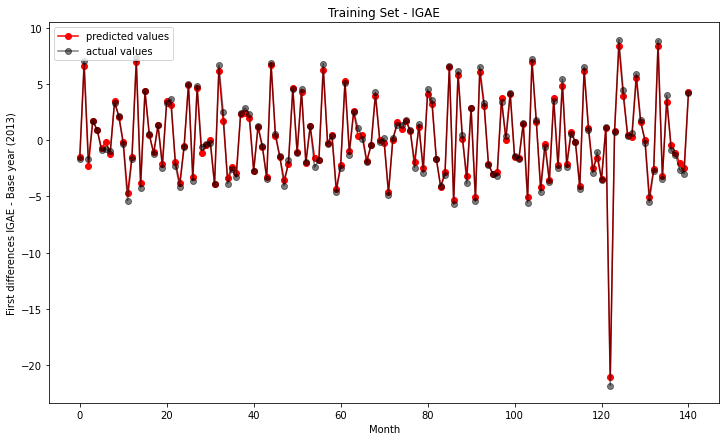

In [41]:
y_train.reset_index(drop=True, inplace=True)
plt.figure(figsize = (12,7))
plt.plot(reg.predict(X_train), c = 'red', label = 'predicted values', marker = '.', markersize = 12)
plt.plot(y_train, c = 'black', label = 'actual values', marker = '.', markersize = 12, alpha = 0.5)
plt.xlabel('Month')
plt.ylabel('First differences IGAE - Base year (2013)')
plt.title('Training Set - IGAE')
plt.legend(loc = "upper left")
plt.rcParams['lines.linewidth'] = 3
plt.show()

[ 3.2555158  0.7270141 -5.175774  -1.7640741  6.71445   -3.1539745
  3.869507  -2.2492468]


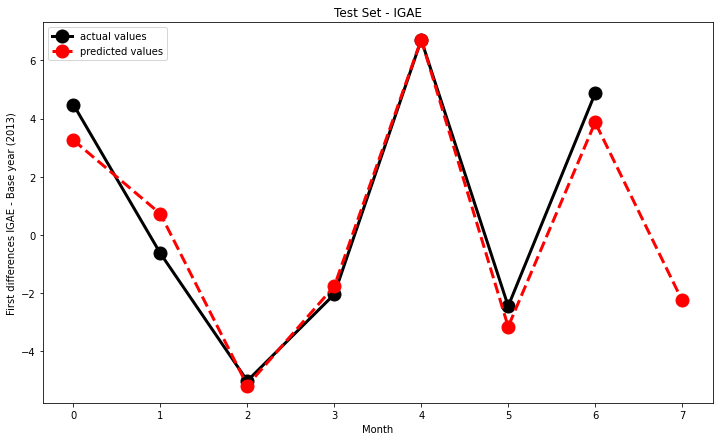

In [87]:
y_test.reset_index(drop=True, inplace=True)
y_hat = reg.predict(X_test)
y_hat = np.append(y_hat, reg.predict(X_val)[0])
print(y_hat)
plt.figure(figsize = (12,7))
plt.plot(y_test, c = 'black', label = 'actual values', marker='o', markersize = 13)
plt.plot(y_hat, c = 'red', label = 'predicted values', linestyle='dashed', marker='o', markersize = 13)
plt.xlabel('Month')
plt.ylabel('First differences IGAE - Base year (2013)')
plt.title('Test Set - IGAE')
plt.legend(loc = "upper left")
plt.rcParams['lines.linewidth'] = 3.0
plt.show()

In [86]:
pd.DataFrame({'Dif_IGAE': y_test, 'Dif_Pred': y_hat[:-1],
              'IGAE': df.IGAE[(len(y_train)+1):-1].values,
              'IGAE_Pred': df.IGAE[(len(y_train)):-2].values+y_hat[:-1]})

,Dif_IGAE,Dif_Pred,IGAE,IGAE_Pred
0,4.480572,3.255516,112.967352,111.742296
1,-0.633421,0.727014,112.333931,113.694366
2,-5.015849,-5.175774,107.318082,107.158157
3,-2.041379,-1.764074,105.276704,105.554008
4,6.703767,6.714450,111.980471,111.991154
5,-2.447685,-3.153975,109.532786,108.826496
6,4.867214,3.869507,114.400000,113.402293


In [100]:
(df.IGAE[148] + reg.predict(X_val)[0]) / df.IGAE[137] * 100 - 100

0.86321329762049

According to the model, the IGAE grew by 0.86 y/y in June 2022.

## Residual diagnostics

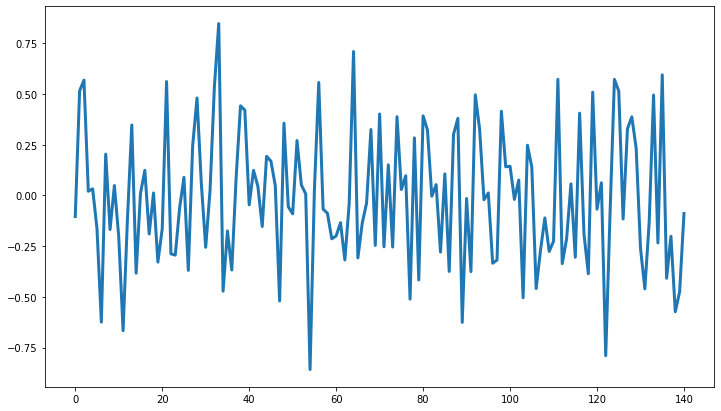

In [101]:
y_train_hat = reg.predict(X_train)
residuals = y_train.values - y_train_hat
plt.figure(figsize = (12, 7))
plt.plot(residuals)

In [102]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sm.stats.jarque_bera(residuals)

lzip(name, test)

[('Jarque-Bera', 1.3625059115404916),
 ('Chi^2 two-tail prob.', 0.505982621184208),
 ('Skew', 0.11850324513421422),
 ('Kurtosis', 2.5807818904110644)]

p. values is greater than 0.05, so the residuals are normally distributed.

In [103]:
sm.stats.durbin_watson(residuals)

2.1392051100282603

Durbin Watson test close to 2, no autocorrelation detected.

# Shapley values

In [104]:
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 7.6 MB/s 


In [105]:
explainer = shap.TreeExplainer(reg)
shap_values = explainer(X_train)

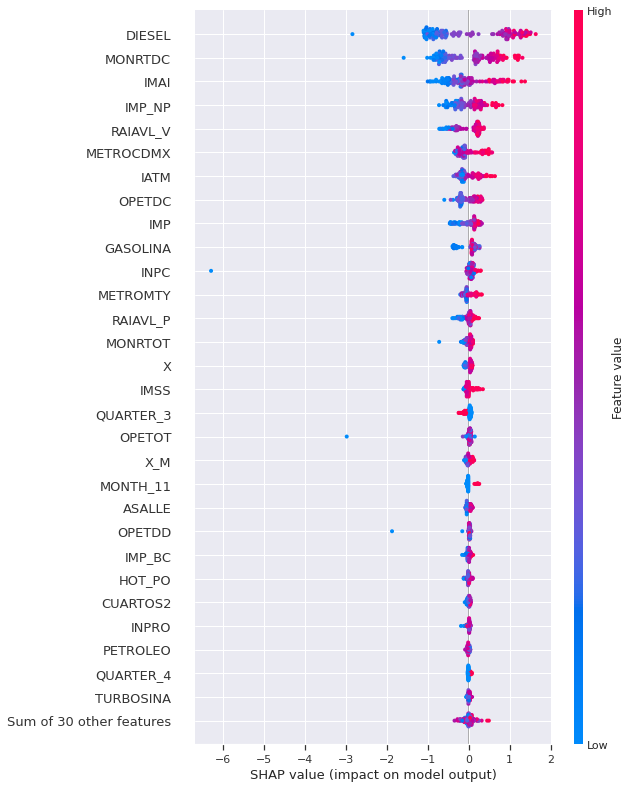

In [108]:
shap.plots.beeswarm(shap_values, max_display = 30)

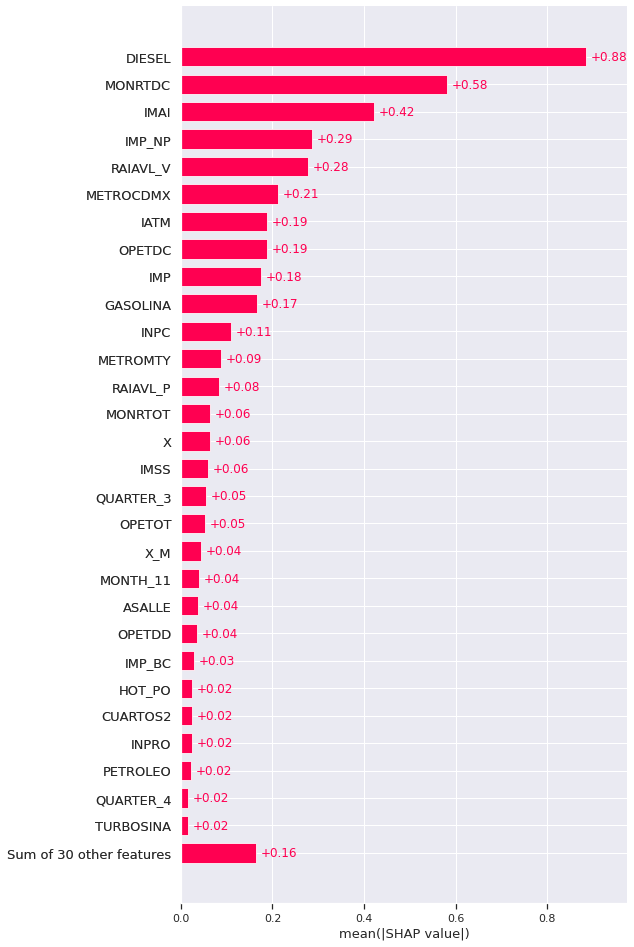

In [111]:
shap.plots.bar(shap_values, max_display = 30)

According to Shapley values, the demand for diesel, expenses via credit cards, the Monthly Industrial Activity Indicator (IMAI), and imports are the most relevant variables in this model.